# Prelim Analysis


In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

<h1>Prepping all the csv files.</h1>
<ul>
    <li>All the data is first downloaded into a single text file.</li>
    <li>The data inside is stored in .csv format so by we change the extension to .csv, so that 
    we can manipulate with pandas and get the individual dataframes for each participant.</li>
    <li>We then extract the individual dataframes and save them as .csv files to the folder Prolific_Data.</li>
    <li>The data processing will then loop over all these individual dataframes and save them to the folder ProcessedData_ForAnalysis.</li>
    <li>Participant data files are given the name "Data_{design_file assigned to that participant}</li>
</ul>

In [106]:
folder_name  = 'Prolific_Data'
prolific_data = os.listdir(folder_name)
save_destination = 'Participant_Data_Raw'

for data_file in prolific_data:
    large_dataframe = pd.read_csv(f"{folder_name}/{data_file}")
    #get all the unique participant ids
    unique_designfiles = large_dataframe['design_file'].unique()
    unique_designfiles = np.delete(unique_designfiles, np.where(unique_designfiles == "design_file"))



for id in unique_designfiles:
    pp_df = large_dataframe[large_dataframe['design_file']== id]

    #as these dfs dont have the unique jatos ids in them, we have to make sure participants who got the same 
    # designfile (duplicates) dont end up getting stacked. Therefore, we shall use the presence of the consent_form
    # to isolate duplicates and save them separately 

    count = (pp_df['url'] == "consent_form.html").value_counts()  
    duplicate_count = count[1] #this is the counts, if it is greater than 1, that means there are duplicates
    
    if duplicate_count > 1:
        start_row_index = 0
        end_row_index = 108 #manually looked this up on the excel file and participant data is 108 rows in total
        for duplicate in range(duplicate_count):
            #break the dataframe into a chunk
            chunk = pp_df.iloc[start_row_index:end_row_index]
            start_row_index = end_row_index
            end_row_index *= 2

            
            #modify the ppid name
            participant_id = id.replace('.csv', '') #strip .csv infront of the designfile name (example:PP01.csv)
            file_name = f"Prolific_Data_{participant_id}_{duplicate}.csv"
            #save it
            chunk.to_csv(f'{save_destination}/{file_name}')



    else:
        participant_id = id
        file_name = f"Prolific_Data_{participant_id}"
        pp_df.to_csv(f'{save_destination}/{file_name}')



## Collect all the initial Feedback

<ul>
 <li>Loop through all the files</li>
 <li>Grab the responses for the survey</li>
 <li>Add them to a list or dictionary</li>
</ul>

In [36]:
import os
folder_name = 'Participant_Data_Raw'
folder = os.listdir(f'{folder_name}')

feedbackSummary = []

for file_name in folder:
    df = pd.read_csv(f'{folder_name}/{file_name}')

    flag = 'survey-text'

    index = df.loc[df['trial_type'] == flag, 'response'].index #grab the index of the row 
    feedback_Object = df.loc[df['trial_type'] == flag, 'response'].to_dict() #this returns a dict with {index of row: contents of row}
    feedback_dictionary = feedback_Object[index[0]] #extract just the dictionary, but it is still a string

    feedback = json.loads(feedback_dictionary)

    feedbackSummary.append(feedback)

with open("Feedback_Summary.txt", 'w') as file:
    json.dump(feedbackSummary, file, indent=4)


    

## Analysing Preferences for monsters for each participant  - First Block
 

In [33]:
#function to calculate the optimal subplot size
def calc_subplots(n_datasets,ncolumns):
    subplots = n_datasets
    columns = ncolumns

    rows = subplots // columns

    if subplots % columns != 0:
        rows +=1 

    return (rows, columns)


In [3]:

imagesPath = 'C:\Master Biosciences\Hiwi Job Heidelberg\monsters'
imagesList = [image for image in os.listdir(imagesPath) if image.endswith('.png')]


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\49374706.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


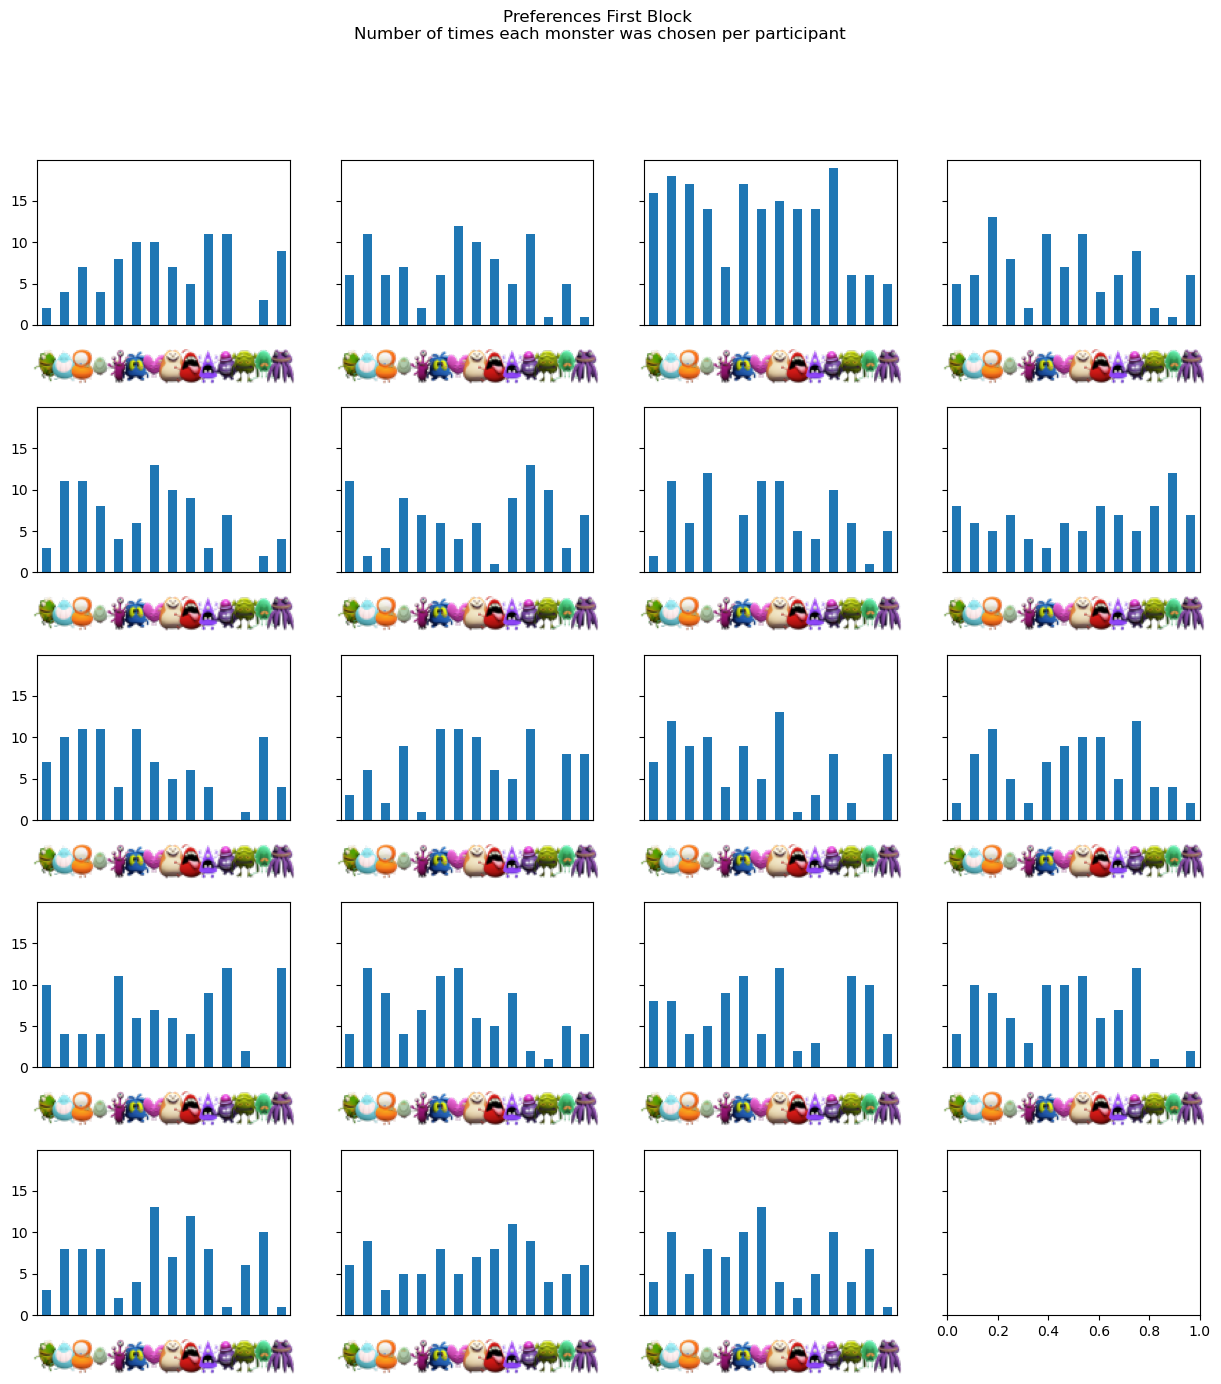

In [50]:
folder_name = 'Participant_Data_Raw'
folder = os.listdir(f"{folder_name}")
n_datasets = len(folder)
columns = 4
subplot = calc_subplots(n_datasets, columns)
figsize = (15,15)


fig, axes = plt.subplots( subplot[0], subplot[1], figsize = figsize, sharey=True)
#we need a consistent xtick labels across all the subplots, so we need to specify the order
imagesPath = 'C:\Master Biosciences\Hiwi Job Heidelberg\monsters'
imagesList = [image for image in os.listdir(imagesPath) if image.endswith('.png')]


for index, file_name in enumerate(folder):
    df = pd.read_csv(f'{folder_name}/{file_name}')

    colstodrop = ['stimulus', 'url','success','plugin_version','view_history']

    firstBlock = df.loc[(df['trial_index'] >= 4) & (df['trial_index'] <=94)]
    firstBlock = firstBlock.drop(colstodrop, axis=1)

    #create a new column which will store the monster chosen by participant
    insert_position = firstBlock.columns.get_loc('rightstim') + 1 #i want the chosen monster column to be inserted after the rightstim column
    firstBlock.insert(insert_position, 'Chosen_Monster', 0)

    #assign the value of the chosen monster based off the key press
    firstBlock.loc[firstBlock['response'] == "ArrowRight", 'Chosen_Monster'] = firstBlock['rightstim']
    firstBlock.loc[firstBlock['response'] == "ArrowLeft", 'Chosen_Monster'] = firstBlock['leftstim']

    #quick plot of the counts of the chosen monsters per participant
    firstBlock['Chosen_Monster'].value_counts().reindex(imagesList).plot(kind='bar', ax = axes.flatten()[index])


    #Replacing the image names with their thumbnails
    axes.flatten()[index].set_xticks([])

    for j, image_path in enumerate(imagesList):
        ##logic
        #load image
        #get thumbnail from image object
        #create a numpy array for using np.asarray as OffsetImage works with numpy arrays
        #create an OffsetImage object (this makes it possible to move the thumbnail to wherever we want) == thumbnail
        #use Annotationbox to place it at (j,0) and then offset it by -30 pts so they appear below the xaxis

        image = Image.open(f"../monsters/{image_path}")
        image.thumbnail((25,25))
        array_image = np.asarray(image)
        thumbnail = OffsetImage(array_image, zoom=1)
        xtick_image = AnnotationBbox(thumbnail, (j,0), xybox = (0,-30), frameon=False,
                                     xycoords='data', boxcoords="offset points", pad=0)
        axes.flatten()[index].add_artist(xtick_image)


plt.subplots_adjust(hspace=0.5)
fig.suptitle(f'Preferences First Block \nNumber of times each monster was chosen per participant')
plt.tight_layout()



## Visualizing sorting arrangements in the Second Block for each participant

## First lets create a workable format with the data:
<h3>Logic</h3>
 <ul>
 <li>Seperate the second block from the main dataframe leaving only the columns we need.</li>
 <li>Extract all the unique sorting criteria</li>
 <li>Based off each criteria, get the final locations of all the monsters (returns a string)</li>
 <li>Then convert the string to a json object</li>
 <li>From the json extract the order of monsters for each criteria and positions of those monsters into separate arrays</li>
    <ul>
        <li>I am splitting the monster order and their respective positions into separate arrays so it makes <br> plotting easier, especially when overlaying the images on top of the points</li>
    </ul>

<li>Create a subplots for each criteria. Use helper function to create an optimal subplot arrangement.</li>
<li>Then for each participant create a subplot with how the monsters are arranged according to their respective criteria
 
 </ul>

In [4]:
path = "C:\Master Biosciences\Hiwi Job Heidelberg\Data_Analysis\Prolific_Results\jatos_results_data_20250520083342.csv"

df = pd.read_csv(path)
secondBlock = df.loc[df['trial_type'] == 'free-sort']
colstodrop = ['stimulus', 'url','success','plugin_version','view_history', 'stimulus',
              'response', 'leftstim', 'rightstim']
secondBlock = secondBlock.drop(colstodrop, axis=1)
sorting_criteria = sorted(secondBlock['sort_criteria'].unique())

sorted_monsters = {} #dictionary to hold the final positions of monsters in the order they were sorted based off criteria
sorted_positions = {} #dictionary to hold the final coordinates of the monsters based off criteria


for criteria in sorting_criteria:

    #grab the value in the respective row and column and convert it to a json so we can work with it
    value = secondBlock.loc[secondBlock['sort_criteria']==criteria, 'final_locations'].squeeze()
    value = json.loads(value)

    monster_order = []
    monster_positions = []
    for i in value:
        monster = i['src']
        monster_order.append(monster)

        x, y = i['x'], i['y']
        coordinates = (x,y)
        monster_positions.append(coordinates)
    
    sorted_monsters[criteria] = monster_order
    sorted_positions[criteria] = monster_positions




Text(0.5, 1.0, 'Colour')

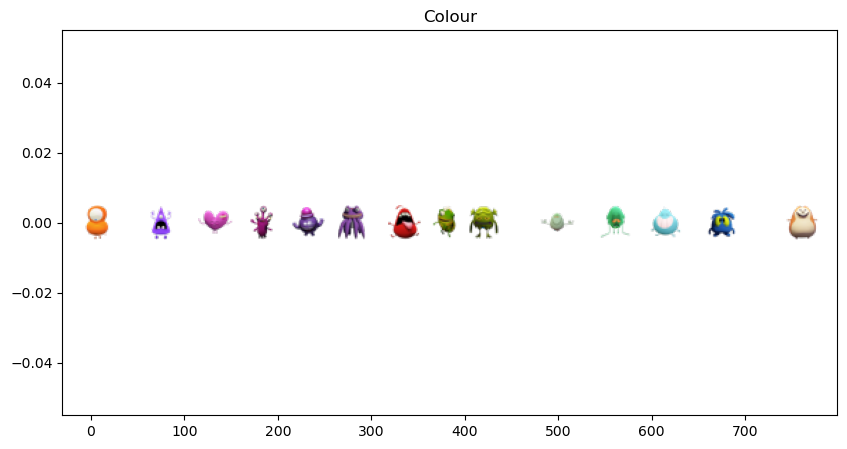

In [16]:

figsize = (10,5)

fig, axes = plt.subplots(figsize=figsize)

positions = sorted_positions['Colour']
m = sorted_monsters['Colour']
for (x,y), image_path in zip(positions,m):
    y = y*0 #this ensures that the original y coordinates are reset to zero so we can visualize all of them on a line
    axes.scatter(x,y)

    img = Image.open(f"../{image_path}")
    img.thumbnail((25,25))
    img_array = np.asarray(img)

    imagebox = OffsetImage(img_array,zoom=1)
    monster = AnnotationBbox(imagebox, (x,y), frameon=False)
    axes.add_artist(monster)

plt.title('Colour')

<h1>Data Processing for statistical analyses</h1>

<h2>Setting up the data for a logistic regression</h2>
<h3>Questions we are trying to answer in simple words:</h3>
    <ul>
    <li>Which criteria do participants use to choose a particular monster in the first block?</li>
    <li>How strong these criterias play a role in the choices of different participants? Does for example cuteness influence one participant more strongly than the other?</li>
    </ul>

<p>We shall use a logistic regression to see how likely a participant is going to choose the left monster based off the different criteria. We use the sorted positions of the monsters for each criteria, from the second block, as a "rating". For example: based off how the monsters are arranged according to cuteness, in every trial we see how any two presented monsters differ in their magnitudes of cuteness, as perceived by the participant. We do this by calculating the difference in the x positions of the left monster and right monster, and then using this difference as a predictor in the logistic regression model. The same applies to all the other criteria and these go into the model as well. We should in the end have 6 predictors (based off the criteria) going into the model which will be then used to see which one of these influences the likelihood of choosing the left monster.</p>

<h2>Logic</h2>
<h3>Code here will be for a single participant (code will be extended for more data below)</h3>
<p>Dependent variable: Chosen Monster.
Independent variable (predictors) : Cuteness, Emotions, Size, Shape, Personal Preference, Colour </p>
    <ul>
    <li>For the dependent variable (Chosen Monster): We code left as 1 and right as 0.</li>
        <ul>
        <li>Create an empty column "Chosen Monster"</li> ✅
        <li>Based off the response column, code 1 in the Chosen Monster column if response == ArrowLeft and code 0 if response ==ArrowRight. </li>✅
        </ul>
    <li>For every participant, we run a logistic regression and see beta coefficients for the predictors.</li>
        <ul>
            <li>Create a main dataframe. Drop all the unwanted columns</li>✅
            <li>Extract the sorted positions for each monster for all the six criteria, just x values.</li>✅
            <li>Make a dataframe where the columns are the criteria (which hold the x values of the monsters from the origin)</li>✅
            <li>In our main dataframe, for every trial (pairing of monsters), we extract the x values for each criteria for the corresponding monsters and make a column each for left and right.</li>✅
            <li>Then we just add new columns where we have the difference values for each pair on each trial, for each criterium</li>✅
            <li>Optionally we can drop the response column, the left and right value columns for the criteria, just to keep the main dataframe less convoluted.</li>
            <li>Optionally we can provide participant ids for the participants and concatenate the main dataframes in the end? Need to double check this.</li>
        </ul>
    </ul>

In [18]:
main_df = pd.read_csv(r"JatosExperiment_Results\jatos_results_data_20250606083413.csv")
colstodrop = ['stimulus', 'url','success','plugin_version','view_history','init_locations', 'question_order', 'moves']
main_df = main_df.drop(colstodrop, axis=1)
main_df = main_df[main_df['trial_index'] > 3]

insert_position = main_df.columns.get_loc('response') + 1 #+1 because i want the index to be that of the column after the response column, i.e. insert my column after the response column
main_df.insert(insert_position, 'Chosen_Monster', 0)

#coding left as 1 and right as 0 
main_df.loc[main_df['response'] == 'ArrowLeft', 'Chosen_Monster'] = 1
main_df.loc[main_df['response'] == 'ArrowRight', 'Chosen_Monster'] = 0


In [19]:
#extracting the positions of the monsters according to criteria
secondBlock = main_df.loc[main_df['trial_type'] == 'free-sort']
sorting_criteria = sorted(secondBlock['sort_criteria'].unique())

sortedPositions = {} #holds monsters and their positions
sorted_final = {} # holds the above dictionary specific to each criteria

for criteria in sorting_criteria:
    #grab the value in the respective row and column and convert it to a json so we can work with it
    value = secondBlock.loc[secondBlock['sort_criteria']==criteria, 'final_locations'].squeeze()
    value = json.loads(value)


    for item in value:
        monster = item['src']
        x_location = item['x']

        sortedPositions[monster] = x_location

    sorted_final[criteria] = sorted(sortedPositions.items()) 



#make a dataframe out of the sorted_final dictionary to hold all the criteria values for each monster
data = {key:dict(value) for key,value in sorted_final.items()} #convert the sorted_final dict values to dictionaries (we create nested dictionaries)

#we need to remove the "monsters/" prefix in the dictionaries
new_data = {} #the dictionary that will contain the criteria : inner dictionary with all the monsters and their values
for key in data: #loop over outer dictionary
    inner_dict = data[key]
    temporary_dict = {} #temporary dictionary which will be the inner dictionary holding the monsters and their criteria values
    for monster_path, item in inner_dict.items():
        new_key = monster_path.removeprefix('monsters/')
        temporary_dict[new_key] = item

    new_data[key] = temporary_dict

monstersdf = pd.DataFrame(new_data)

monstersdf


,Colour,Cuteness,Emotions(Intensity),Emotions(Valence),Personal preference,Shape,Size
obj00.png,138,105,15,118,75,166,84
obj01.png,281,353,68,606,776,721,90
obj02.png,401,313,93,149,85,693,583
obj03.png,19,218,85,523,111,526,166
obj04.png,638,157,166,257,747,281,543
obj05.png,341,566,109,426,645,513,123
obj06.png,584,736,397,335,681,35,463
obj07.png,216,775,775,661,724,707,780
obj09.png,519,212,496,312,158,341,162
obj11.png,690,502,782,117,620,31,631


In [20]:
#only including trials from the first block and removing unnecessary rows
main_df = main_df[ (main_df['trial_type'] == 'html-keyboard-response') & (main_df['trial_index'] <=94)]
main_df = main_df.drop(['sort_criteria', 'final_locations'],axis=1)
main_df

,rt,response,Chosen_Monster,trial_type,trial_index,time_elapsed,design_file,leftstim,rightstim
4,2896,ArrowLeft,1,html-keyboard-response,4,74324,PP001.csv,obj02.png,obj00.png
5,1340,ArrowRight,0,html-keyboard-response,5,77080,PP001.csv,obj14.png,obj05.png
6,1560,ArrowLeft,1,html-keyboard-response,6,80055,PP001.csv,obj06.png,obj00.png
7,1496,ArrowLeft,1,html-keyboard-response,7,82967,PP001.csv,obj12.png,obj09.png
8,947,ArrowLeft,1,html-keyboard-response,8,85337,PP001.csv,obj05.png,obj06.png
...,...,...,...,...,...,...,...,...,...
90,797,ArrowLeft,1,html-keyboard-response,90,283468,PP001.csv,obj03.png,obj01.png
91,704,ArrowRight,0,html-keyboard-response,91,285589,PP001.csv,obj03.png,obj04.png
92,583,ArrowRight,0,html-keyboard-response,92,287599,PP001.csv,obj09.png,obj11.png
93,538,ArrowLeft,1,html-keyboard-response,93,289554,PP001.csv,obj05.png,obj02.png


In [21]:
#we have a monstersdf with all the values for monsters according to the criteria from the second block sorting task
#we have the main dataframe

#we start by adding the columns which will hold the differences between the left and right monster according to a criteria
#the difference is calculated by value(left) - value(right)

cols_toadd = ['Color_d','Cuteness_d','Emotions(Valence)_d', 'Emotions(Intensity)_d', 'Personal_Preference_d','Shape_d','Size_d']
insert_position = main_df.columns.get_loc('rightstim') + 1

for index, column in enumerate(cols_toadd):
    main_df.insert(insert_position + index, column, np.nan)

main_df


,rt,response,Chosen_Monster,trial_type,trial_index,time_elapsed,design_file,leftstim,rightstim,Color_d,Cuteness_d,Emotions(Valence)_d,Emotions(Intensity)_d,Personal_Preference_d,Shape_d,Size_d
4,2896,ArrowLeft,1,html-keyboard-response,4,74324,PP001.csv,obj02.png,obj00.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1340,ArrowRight,0,html-keyboard-response,5,77080,PP001.csv,obj14.png,obj05.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1560,ArrowLeft,1,html-keyboard-response,6,80055,PP001.csv,obj06.png,obj00.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1496,ArrowLeft,1,html-keyboard-response,7,82967,PP001.csv,obj12.png,obj09.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,947,ArrowLeft,1,html-keyboard-response,8,85337,PP001.csv,obj05.png,obj06.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,797,ArrowLeft,1,html-keyboard-response,90,283468,PP001.csv,obj03.png,obj01.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,704,ArrowRight,0,html-keyboard-response,91,285589,PP001.csv,obj03.png,obj04.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,583,ArrowRight,0,html-keyboard-response,92,287599,PP001.csv,obj09.png,obj11.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,538,ArrowLeft,1,html-keyboard-response,93,289554,PP001.csv,obj05.png,obj02.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#now lets start calculating the differences for each pair of stimuli shown to the participant (left - right) for each
#of the sorting criteria

main_df = main_df.copy()

for index,stimulus in enumerate(main_df['leftstim']):
    #get the pair of stimuli
    left_monster = stimulus
    right_monster = main_df['rightstim'].iloc[index]
    
    #get all the values for criteria of the monster pairings (per trial)
    colour_left = monstersdf.loc[monstersdf.index == left_monster, 'Colour'].values[0]
    colour_right = monstersdf.loc[monstersdf.index == right_monster, 'Colour'].values[0]

    cuteness_left = monstersdf.loc[monstersdf.index == left_monster, 'Cuteness'].values[0]
    cuteness_right = monstersdf.loc[monstersdf.index == right_monster, 'Cuteness'].values[0]

    emotions_valence_left = monstersdf.loc[monstersdf.index == left_monster, 'Emotions(Valence)'].values[0]
    emotions_valence_right = monstersdf.loc[monstersdf.index == right_monster, 'Emotions(Valence)'].values[0]

    	
    emotions_intensity_left = monstersdf.loc[monstersdf.index == left_monster, 'Emotions(Intensity)'].values[0]
    emotions_intensity_right = monstersdf.loc[monstersdf.index == right_monster, 'Emotions(Intensity)'].values[0]
    
    personal_left = monstersdf.loc[monstersdf.index == left_monster, 'Personal preference'].values[0]
    personal_right = monstersdf.loc[monstersdf.index == right_monster, 'Personal preference'].values[0]

    shape_left = monstersdf.loc[monstersdf.index == left_monster, 'Shape'].values[0]
    shape_right = monstersdf.loc[monstersdf.index == right_monster, 'Shape'].values[0]

    size_left = monstersdf.loc[monstersdf.index == left_monster, 'Size'].values[0]
    size_right = monstersdf.loc[monstersdf.index == right_monster, 'Size'].values[0]


    #calculate the difference in the criteria between the monster pairings 
    colour_d = colour_left - colour_right
    cuteness_d = cuteness_left - cuteness_right
    emotions_valence_d = emotions_valence_left - emotions_valence_right
    emotions_intensity_d = emotions_intensity_left - emotions_intensity_right
    personal_d = personal_left - personal_right
    shape_d = shape_left - shape_right
    size_d = size_left - size_right

    #add it to the exact row of the criteria difference columns
    main_df['Color_d'].iloc[index] = colour_d
    main_df['Cuteness_d'].iloc[index] = cuteness_d
    main_df['Emotions(Valence)_d'].iloc[index] = emotions_valence_d
    main_df['Emotions(Intensity)_d'].iloc[index] = emotions_intensity_d
    main_df['Personal_Preference_d'].iloc[index] = personal_d
    main_df['Shape_d'].iloc[index] = shape_d
    main_df['Size_d'].iloc[index] = size_d

    
    

main_df



    

C:\Users\Rishi\AppData\Local\Temp\ipykernel_7316\2755009165.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_7316\2755009165.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_7316\2755009165.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Em

,rt,response,Chosen_Monster,trial_type,trial_index,time_elapsed,design_file,leftstim,rightstim,Color_d,Cuteness_d,Emotions(Valence)_d,Emotions(Intensity)_d,Personal_Preference_d,Shape_d,Size_d
4,2896,ArrowLeft,1,html-keyboard-response,4,74324,PP001.csv,obj02.png,obj00.png,263.0,208.0,31.0,78.0,10.0,527.0,499.0
5,1340,ArrowRight,0,html-keyboard-response,5,77080,PP001.csv,obj14.png,obj05.png,121.0,-370.0,-380.0,-8.0,-604.0,-340.0,-107.0
6,1560,ArrowLeft,1,html-keyboard-response,6,80055,PP001.csv,obj06.png,obj00.png,446.0,631.0,217.0,382.0,606.0,-131.0,379.0
7,1496,ArrowLeft,1,html-keyboard-response,7,82967,PP001.csv,obj12.png,obj09.png,223.0,464.0,468.0,111.0,612.0,4.0,375.0
8,947,ArrowLeft,1,html-keyboard-response,8,85337,PP001.csv,obj05.png,obj06.png,-243.0,-170.0,91.0,-288.0,-36.0,478.0,-340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,797,ArrowLeft,1,html-keyboard-response,90,283468,PP001.csv,obj03.png,obj01.png,-262.0,-135.0,-83.0,17.0,-665.0,-195.0,76.0
91,704,ArrowRight,0,html-keyboard-response,91,285589,PP001.csv,obj03.png,obj04.png,-619.0,61.0,266.0,-81.0,-636.0,245.0,-377.0
92,583,ArrowRight,0,html-keyboard-response,92,287599,PP001.csv,obj09.png,obj11.png,-171.0,-290.0,195.0,-286.0,-462.0,310.0,-469.0
93,538,ArrowLeft,1,html-keyboard-response,93,289554,PP001.csv,obj05.png,obj02.png,-60.0,253.0,277.0,16.0,560.0,-180.0,-460.0


In [ ]:
#save the main data frame as well as the monsters dataframe with the values

main_df.to_csv('Main_df.csv')
monstersdf.to_csv('Monster_Criteria_Values.csv')

<h1>Data Processing Pipeline for Analyses</h1>
<p>The above code was for a single participant from prolific. The below code would run for datasets which we collect from prolific.</p>
<p>There are a few pipelines which prep the data for other analyses as well</p>


In [128]:
#load up the folder with our data sets
file_name = 'Participant_Data_Raw'
Datasets = os.listdir(file_name)

check_duplicates = [] #an empty array to hold ppid values (Designfile ids) #should any participant have any duplicates
#we can cross check with it here and adjust the ppid for the filename accordingly
duplicate_count = 0

#loop through each dataset and do the above processing steps
for participant_data in Datasets:

    #get the last digits as an ID 
    # ppID = ''.join(character for character in participant_data if character.isdigit())
    
    #load up the data frame
    main_df = pd.read_csv(f"{file_name}/{participant_data}")
    
    designfile_id = main_df['design_file'].unique()[0]
    ppID = ''

    if designfile_id in check_duplicates: 
        duplicate_count +=1 
        ppID = designfile_id.replace(".csv",'')
        ppID = f"{ppID}_{duplicate_count}"
        print(ppID)

    else:
        check_duplicates.append(designfile_id)
        ppID = designfile_id.replace(".csv", '')
        print(ppID)


    



    #drop unnecessary columns
    colstodrop = ['stimulus', 'url','success','plugin_version','view_history','init_locations', 'question_order', 'moves']
    main_df = main_df.drop(colstodrop, axis=1)
    main_df = main_df[main_df['trial_index'] > 3]

    #creating and inserting our column which stores the chosen monster data (left or right)
    insert_position = main_df.columns.get_loc('response') + 1 #+1 because i want the index to be that of the column after the response column, i.e. insert my column after the response column
    main_df.insert(insert_position, 'Chosen_Monster', 0)

    #coding left as 1 and right as 0 
    main_df.loc[main_df['response'] == 'ArrowLeft', 'Chosen_Monster'] = 1
    main_df.loc[main_df['response'] == 'ArrowRight', 'Chosen_Monster'] = 0

    #extracting the second block from our dataframe to work with sorting criteria data 
    secondBlock = main_df.loc[main_df['trial_type'] == 'free-sort']
    sorting_criteria = sorted(secondBlock['sort_criteria'].unique())

    sortedPositions = {} #holds monsters and their positions
    sorted_final = {} # holds the above dictionary specific to each criteria

    for criteria in sorting_criteria:
        #grab the value in the respective row and column and convert it to a json so we can work with it
        value = secondBlock.loc[secondBlock['sort_criteria']==criteria, 'final_locations'].squeeze()
        value = json.loads(value)


        for item in value:
            monster = item['src']
            x_location = item['x']

            sortedPositions[monster] = x_location

        sorted_final[criteria] = sorted(sortedPositions.items()) 

    #make a dataframe out of the sorted_final dictionary to hold all the criteria values for each monster
    data = {key:dict(value) for key,value in sorted_final.items()} #convert the sorted_final dict values to dictionaries (we create nested dictionaries)

    #we need to remove the "monsters/" prefix in the dictionaries
    new_data = {} #the dictionary that will contain the criteria : inner dictionary with all the monsters and their values
    for key in data: #loop over outer dictionary
        inner_dict = data[key]
        temporary_dict = {} #temporary dictionary which will be the inner dictionary holding the monsters and their criteria values
        for monster_path, item in inner_dict.items():
            new_key = monster_path.removeprefix('monsters/')
            temporary_dict[new_key] = item

        new_data[key] = temporary_dict

    monstersdf = pd.DataFrame(new_data) #this holds all the values of the positions of the monsters for each criteria
    monstersdf.to_csv(f'Monsters_dfs/Monstersdf_{ppID}.csv') #save the dataframes for our analysis where we want to check if the dimensions can be used to predict personal preference


    ##now we re-adjust the main dataframe and clean it up a bit more with the following steps 

    #only including trials from the first block and removing unnecessary rows
    main_df = main_df[ (main_df['trial_type'] == 'html-keyboard-response') & (main_df['trial_index'] <=94)]
    main_df = main_df.drop(['sort_criteria', 'final_locations'],axis=1)

    #we have a monstersdf with all the values for monsters according to the criteria from the second block sorting task
    #we have the main dataframe

    #we start by adding the columns which will hold the differences between the left and right monster according to a criteria
    #the difference is calculated by value(left) - value(right)
    cols_toadd = ['Color_d','Cuteness_d','Emotions(Valence)_d', 'Emotions(Intensity)_d', 'Personal_Preference_d','Shape_d','Size_d']
    insert_position = main_df.columns.get_loc('rightstim') + 1

    for index, column in enumerate(cols_toadd):
        main_df.insert(insert_position + index, column, np.nan)
    
    for index,stimulus in enumerate(main_df['leftstim']):
        #get the pair of stimuli
        left_monster = stimulus
        right_monster = main_df['rightstim'].iloc[index]
        
        colour_left = monstersdf.loc[monstersdf.index == left_monster, 'Colour'].values[0]
        colour_right = monstersdf.loc[monstersdf.index == right_monster, 'Colour'].values[0]

        cuteness_left = monstersdf.loc[monstersdf.index == left_monster, 'Cuteness'].values[0]
        cuteness_right = monstersdf.loc[monstersdf.index == right_monster, 'Cuteness'].values[0]

        emotions_valence_left = monstersdf.loc[monstersdf.index == left_monster, 'Emotions(Valence)'].values[0]
        emotions_valence_right = monstersdf.loc[monstersdf.index == right_monster, 'Emotions(Valence)'].values[0]

            
        emotions_intensity_left = monstersdf.loc[monstersdf.index == left_monster, 'Emotions(Intensity)'].values[0]
        emotions_intensity_right = monstersdf.loc[monstersdf.index == right_monster, 'Emotions(Intensity)'].values[0]
        
        personal_left = monstersdf.loc[monstersdf.index == left_monster, 'Personal preference'].values[0]
        personal_right = monstersdf.loc[monstersdf.index == right_monster, 'Personal preference'].values[0]

        shape_left = monstersdf.loc[monstersdf.index == left_monster, 'Shape'].values[0]
        shape_right = monstersdf.loc[monstersdf.index == right_monster, 'Shape'].values[0]

        size_left = monstersdf.loc[monstersdf.index == left_monster, 'Size'].values[0]
        size_right = monstersdf.loc[monstersdf.index == right_monster, 'Size'].values[0]


        #calculate the difference in the criteria between the monster pairings 
        colour_d = colour_left - colour_right
        cuteness_d = cuteness_left - cuteness_right
        emotions_valence_d = emotions_valence_left - emotions_valence_right
        emotions_intensity_d = emotions_intensity_left - emotions_intensity_right
        personal_d = personal_left - personal_right
        shape_d = shape_left - shape_right
        size_d = size_left - size_right

        #add it to the exact row of the criteria difference columns
        main_df['Color_d'].iloc[index] = colour_d
        main_df['Cuteness_d'].iloc[index] = cuteness_d
        main_df['Emotions(Valence)_d'].iloc[index] = emotions_valence_d
        main_df['Emotions(Intensity)_d'].iloc[index] = emotions_intensity_d
        main_df['Personal_Preference_d'].iloc[index] = personal_d
        main_df['Shape_d'].iloc[index] = shape_d
        main_df['Size_d'].iloc[index] = size_d

        #save the dataframe as a .csv #this is for our logistic regression analysis
        main_df.to_csv(f'ProcessedData_ForAnalysis/Data_{ppID}.csv')




PP001


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP010


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP012


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP012_1


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP026


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP028


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP029


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP034


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP036


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP039


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP043


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP044


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP047


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP059


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP062


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP069


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP076


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP085


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP093


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

PP099


C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Color_d'].iloc[index] = colour_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['Cuteness_d'].iloc[index] = cuteness_d
C:\Users\Rishi\AppData\Local\Temp\ipykernel_18424\1203250318.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_

In [36]:
main_df

,rt,response,Chosen_Monster,trial_type,trial_index,time_elapsed,design_file,leftstim,rightstim,Color_d,Cuteness_d,Emotions(Valence)_d,Emotions(Intensity)_d,Personal_Preference_d,Shape_d,Size_d
4,2896,ArrowLeft,1,html-keyboard-response,4,74324,PP001.csv,obj02.png,obj00.png,263.0,208.0,31.0,78.0,10.0,527.0,499.0
5,1340,ArrowRight,0,html-keyboard-response,5,77080,PP001.csv,obj14.png,obj05.png,121.0,-370.0,-380.0,-8.0,-604.0,-340.0,-107.0
6,1560,ArrowLeft,1,html-keyboard-response,6,80055,PP001.csv,obj06.png,obj00.png,446.0,631.0,217.0,382.0,606.0,-131.0,379.0
7,1496,ArrowLeft,1,html-keyboard-response,7,82967,PP001.csv,obj12.png,obj09.png,223.0,464.0,468.0,111.0,612.0,4.0,375.0
8,947,ArrowLeft,1,html-keyboard-response,8,85337,PP001.csv,obj05.png,obj06.png,-243.0,-170.0,91.0,-288.0,-36.0,478.0,-340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,797,ArrowLeft,1,html-keyboard-response,90,283468,PP001.csv,obj03.png,obj01.png,-262.0,-135.0,-83.0,17.0,-665.0,-195.0,76.0
91,704,ArrowRight,0,html-keyboard-response,91,285589,PP001.csv,obj03.png,obj04.png,-619.0,61.0,266.0,-81.0,-636.0,245.0,-377.0
92,583,ArrowRight,0,html-keyboard-response,92,287599,PP001.csv,obj09.png,obj11.png,-171.0,-290.0,195.0,-286.0,-462.0,310.0,-469.0
93,538,ArrowLeft,1,html-keyboard-response,93,289554,PP001.csv,obj05.png,obj02.png,-60.0,253.0,277.0,16.0,560.0,-180.0,-460.0
